In [2]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
from datetime import date,datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score 
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime
import sys
sys.path.append(R'C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Scoring Worlflow')

# Upload Scores to DWH

In [3]:
df = pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\scored_income_2019.pkl")

In [3]:
df= df[["SKP_CREDIT_CASE","PRED_INCOME"]]

In [4]:
df.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\scored_income_upload_dwh.csv", index = False)

In [5]:
#upload to TBD_INCOME_PRED

# Read Data File

In [7]:
df= pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\scored_income_2019.pkl")


In [73]:
df1 = pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\data_dump_income_pred.pkl")

In [74]:
df1= df1[['SKP_CREDIT_CASE','CLIENT_DEBT', 'CLIENT_EMI','NTC_FLAG']]

In [75]:
df = df.merge(df1, on= 'SKP_CREDIT_CASE', how = 'inner')

# Create features for Analysis 

In [77]:
df.columns= ['SKP_CREDIT_CASE', 'TIME_DECISION_DATE', 'CUS_LAT', 'CUS_LONG',
       'RISK_FSTQPD30', 'RISK_SCORE', 'GRID_ID', 'REPORTED_INCOME',
       'MONTH_STR', 'PRED_INCOME', 'CLIENT_DEBT', 'CLIENT_EMI', 'NTC_FLAG']

In [78]:
features_list = ["REPORTED_INCOME","PRED_INCOME","MIN_INCOME","RATIO_PRED_REPORTED_INCOME","DTI_PRED_INCOME","DTI_REPORTED_INCOME","DTI_MIN_INCOME"]

In [79]:
df["MIN_INCOME"] = df[['REPORTED_INCOME','PRED_INCOME']].min(axis=1)

In [80]:
df["RATIO_PRED_REPORTED_INCOME"] = df['PRED_INCOME']/df['REPORTED_INCOME']

In [81]:
df["DTI_PRED_INCOME"] = [(df["CLIENT_DEBT"][x]+ df["CLIENT_EMI"][x]+1500)/df["PRED_INCOME"][x] for x in df.index]
df["DTI_REPORTED_INCOME"] = [(df["CLIENT_DEBT"][x]+ df["CLIENT_EMI"][x]+1500)/df["REPORTED_INCOME"][x] for x in df.index]
df["DTI_MIN_INCOME"] = [(df["CLIENT_DEBT"][x]+ df["CLIENT_EMI"][x]+1500)/df["MIN_INCOME"][x] for x in df.index]


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [129]:
df.shape

(2427841, 18)

In [138]:
df = df[~df["MIN_INCOME"].isin([0,np.inf,np.nan])]

In [139]:
df.to_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\scored_income_v1.pkl")

# MOM R Square

In [140]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score 

In [206]:
dic= {"MONTH_STR":[],"RMSE":[],"R_SQUARED":[]}
for x in df.MONTH_STR.unique():
    dic["MONTH_STR"].append(x)
    dic["RMSE"].append(round(np.sqrt(mse(df[df.MONTH_STR==x]["REPORTED_INCOME"],df[df.MONTH_STR==x]["PRED_INCOME"]))))
    dic["R_SQUARED"].append(r2_score(df[df.MONTH_STR==x]["REPORTED_INCOME"],df[df.MONTH_STR==x]["PRED_INCOME"]))
    
r_sq_df = pd.DataFrame(dic)

r_sq_df

,MONTH_STR,RMSE,R_SQUARED
0,2019-01,5447.0,0.120934
1,2019-02,5340.0,0.123691
2,2019-03,5548.0,0.119918
3,2019-04,5552.0,0.121939
4,2019-05,5895.0,0.108702
5,2019-06,5889.0,0.104299
6,2019-07,5900.0,0.109082
7,2019-08,5845.0,0.116139


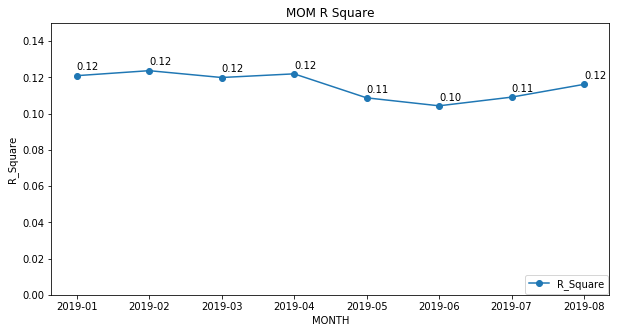

In [222]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(r_sq_df["MONTH_STR"],r_sq_df["R_SQUARED"], marker = 'o', label = 'R_Square')

for i, txt in enumerate(r_sq_df["R_SQUARED"]):
    plt.annotate("{:.2f}".format(txt), (r_sq_df["MONTH_STR"][i], r_sq_df["R_SQUARED"][i]+0.003))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,0.15)
plt.ylabel("R_Square")
plt.xlabel("MONTH")
ax1.set_title("MOM R Square")
plt.show()

# Gini and IV of Features for Comparison

In [165]:
df1=df

### Reduce sample size to reduce computation in calculations for IV, Gini

In [198]:
df = df1.sample(n=300000,random_state=2)

In [199]:
for x in features_list:
    df[x+"_BINS"] = pd.qcut(df[x],10,duplicates = 'drop')

In [202]:
from scoring.metrics import iv,gini
cols_list= features_list
col_target= 'RISK_FSTQPD30'
power_tab = {'VARIABLE_NAME':[],'IV':[],'GINI':[]}
for j in range(0,len(cols_list)):
        power_tab["VARIABLE_NAME"].append(cols_list[j])
        power_tab["IV"].append("{:.2%}".format(iv(df[col_target],df[cols_list[j]+"_BINS"])))
        power_tab["GINI"].append("{:.2%}".format((2*metrics.roc_auc_score(df[col_target],df[cols_list[j]])-1)))
        print(cols_list[j])

REPORTED_INCOME
PRED_INCOME
MIN_INCOME
RATIO_PRED_REPORTED_INCOME
DTI_PRED_INCOME
DTI_REPORTED_INCOME
DTI_MIN_INCOME


In [204]:
power_out = pd.DataFrame(power_tab)
power_out = power_out.set_index('VARIABLE_NAME')
power_out = power_out.sort_values('GINI',ascending=False)

pd.options.display.max_rows = 1000
display(power_out)

power_out.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\gini_iv.csv")

,IV,GINI
VARIABLE_NAME,,
DTI_PRED_INCOME,1.44%,5.92%
DTI_MIN_INCOME,1.01%,5.64%
DTI_REPORTED_INCOME,0.52%,4.04%
PRED_INCOME,0.30%,2.68%
MIN_INCOME,0.22%,1.78%
REPORTED_INCOME,0.12%,1.24%
RATIO_PRED_REPORTED_INCOME,0.04%,-0.46%


### To make MOM calculations of IV, GINI

In [ ]:
from scoring.metrics import iv,gini,lift
cols_list= features_list
col_target= 'RISK_FSTQPD30'
power_tab = {'VARIABLE_NAME':[],'MONTH':[],'IV':[],'GINI':[]}
for j in range(0,len(cols_list)):
    for k in df.MONTH_STR.unique():
        power_tab["VARIABLE_NAME"].append(j)
        power_tab["MONTH"].append(k)
        power_tab["IV"].append("{:.1%}".format(iv(df[df.MONTH_STR==k][col_target],df[df.MONTH_STR==k][cols_list[j]+"_BINS"])))
        power_tab["GINI"].append("{:.1%}".format((2*metrics.roc_auc_score(df[df.MONTH_STR==k][col_target],df[df.MONTH_STR==k][cols_list[j]])-1)))

In [ ]:
power_out = pd.DataFrame(power_tab)
power_out = power_out.set_index('VARIABLE_NAME')
power_out = power_out.sort_values('Gini',ascending=False)

pd.options.display.max_rows = 1000
display(power_out)

power_out.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\mom_gini_iv.csv")

# WOE Analysis

In [143]:
df=df1
# Split Train and Test Data Set
df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 1, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 3, 31))]
df_valid = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 4, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 5, 31))]
df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 6, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 8, 31))]

In [145]:
cols_pred_num=features_list
cols_pred_cat = []

In [ ]:
from scoring.grouping import Grouping

grouping = Grouping(columns = sorted(cols_pred_num),
                    cat_columns = sorted(cols_pred_cat),
                    group_count=4, 
                    min_samples=100000)

grouping.fit(df_train[cols_pred_num],
             df_train["RISK_FSTQPD30"],
          #   w=data[train_mask][col_weight],
            progress_bar=True, category_limit=10000);

grouping.save(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\my_grouping")

data_woe = grouping.transform(df, transform_to='woe', progress_bar=True)

### Plot Bins

***

### DTI_MIN_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_DTI_MIN_INCOME,,,,,,,,
"[-inf, 0.1993)",333939.0,23912.0,0.0716,0.3647,0.4029,0.0984,0.0996,0.3999
"[0.1993, 0.2267)",188476.0,14475.0,0.0768,0.2207,0.2261,0.0237,0.0240,0.2257
"[0.2267, 0.2544)",131065.0,10512.0,0.0802,0.1603,0.1567,-0.0228,-0.0231,0.1569
"[0.2544, inf)",181631.0,16673.0,0.0918,0.2543,0.2144,-0.1689,-0.1707,0.2175
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.4626,0.0000


IV: 0.0108
Gini: 5.55


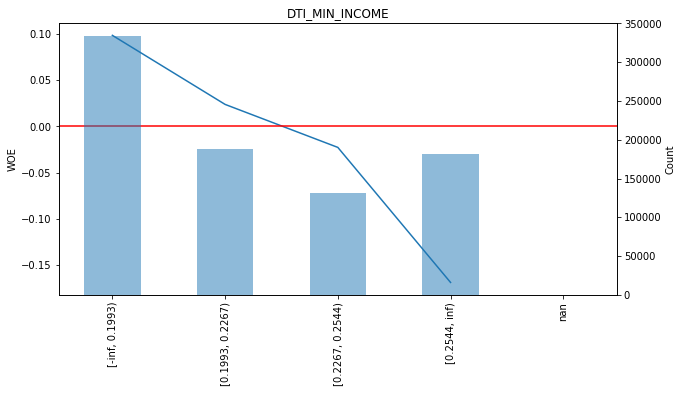

***

### DTI_PRED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_DTI_PRED_INCOME,,,,,,,,
"[-inf, 0.1729)",283209.0,20350.0,0.0719,0.3103,0.3416,0.0947,0.0959,0.3391
"[0.1729, 0.1945)",210636.0,15637.0,0.0742,0.2385,0.2534,0.0600,0.0607,0.2522
"[0.1945, 0.235)",237371.0,18712.0,0.0788,0.2854,0.2841,-0.0042,-0.0043,0.2842
"[0.235, inf)",103895.0,10873.0,0.1047,0.1658,0.1209,-0.3129,-0.3161,0.1244
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.4626,0.0000


IV: 0.0181
Gini: 6.16


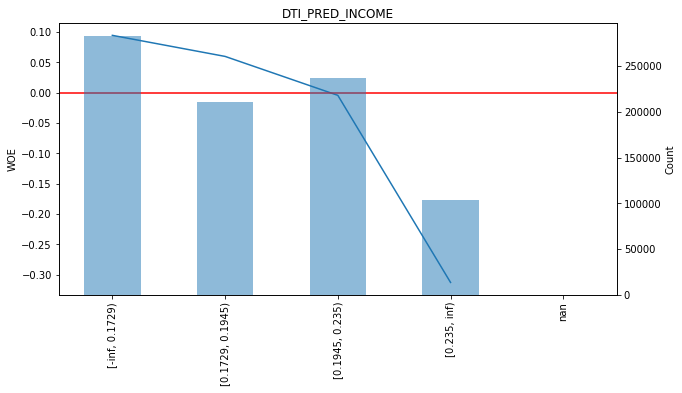

***

### DTI_REPORTED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_DTI_REPORTED_INCOME,,,,,,,,
"[-inf, 0.1562)",177683.0,12980.0,0.0731,0.1980,0.2140,0.0771,0.0781,0.2128
"[0.1562, 0.191)",200774.0,15134.0,0.0754,0.2308,0.2412,0.0437,0.0442,0.2404
"[0.191, 0.2442)",269800.0,21325.0,0.0790,0.3252,0.3229,-0.0071,-0.0072,0.3231
"[0.2442, inf)",186854.0,16133.0,0.0863,0.2460,0.2218,-0.1023,-0.1035,0.2237
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.4626,0.0000


IV: 0.0042
Gini: 3.55


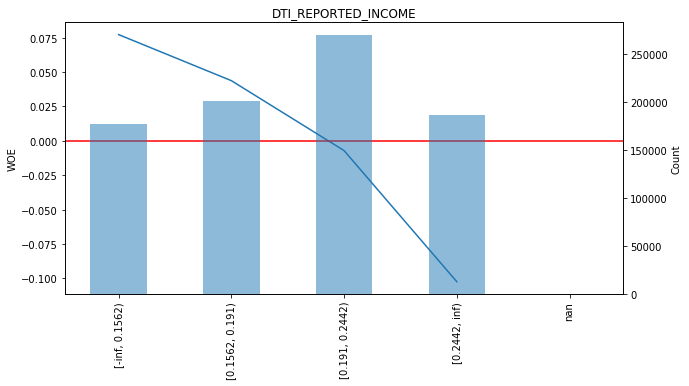

***

### MIN_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_MIN_INCOME,,,,,,,,
"[-inf, 13988.6914)",211056.0,15694.0,0.0744,0.2393,0.2539,0.0582,0.0589,0.2527
"[13988.6914, 17489.7734)",389018.0,30048.0,0.0772,0.4582,0.4665,0.0176,0.0178,0.4658
"[17489.7734, 18856.7148)",133042.0,10695.0,0.0804,0.1631,0.1590,-0.0253,-0.0256,0.1593
"[18856.7148, inf)",101995.0,9135.0,0.0896,0.1393,0.1207,-0.1421,-0.1437,0.1221
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.4626,0.0000


IV: 0.0038
Gini: 2.99


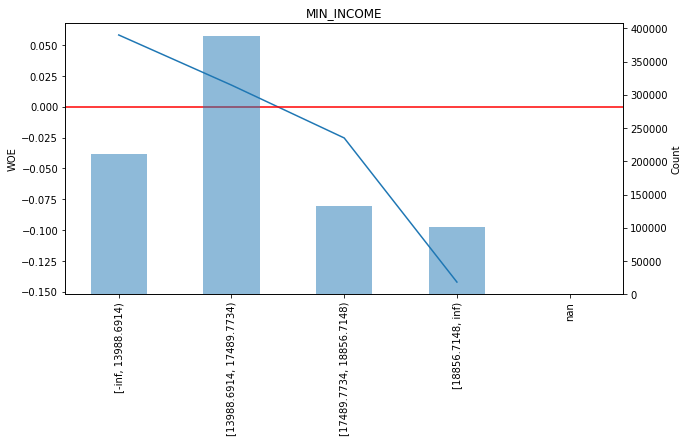

***

### PRED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_PRED_INCOME,,,,,,,,
"[-inf, 14689.6084)",102583.0,7315.0,0.0713,0.1116,0.1238,0.1028,0.1041,0.1228
"[14689.6084, 15632.2114)",104097.0,7722.0,0.0742,0.1178,0.1252,0.0608,0.0615,0.1247
"[15632.2114, 19756.7314)",527665.0,41085.0,0.0779,0.6266,0.6323,0.0090,0.0091,0.6319
"[19756.7314, inf)",100766.0,9450.0,0.0938,0.1441,0.1187,-0.1923,-0.1943,0.1207
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.4626,0.0000


IV: 0.0067
Gini: 3.71


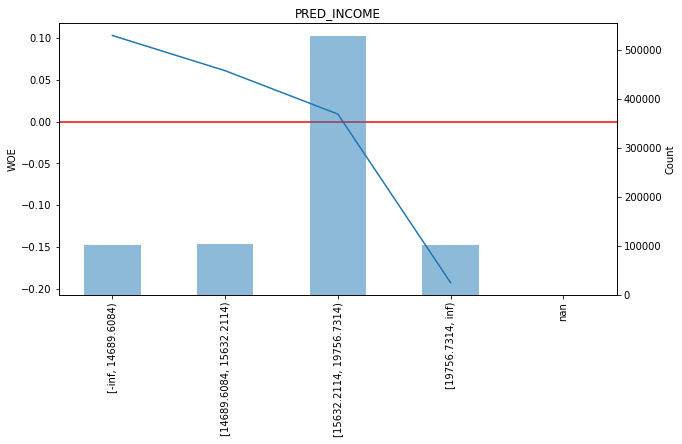

***

### RATIO_PRED_REPORTED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_RATIO_PRED_REPORTED_INCOME,,,,,,,,
"[-inf, 0.7458)",100000.0,8637.0,0.0864,0.1317,0.1187,-0.1027,-0.1039,0.1197
"[0.7458, 0.9057)",135033.0,10573.0,0.0783,0.1612,0.1617,0.0030,0.0030,0.1617
"[0.9057, 1.03)",161625.0,12291.0,0.0760,0.1874,0.1941,0.0343,0.0347,0.1935
"[1.03, inf)",438453.0,34071.0,0.0777,0.5196,0.5255,0.0111,0.0113,0.5250
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.4626,0.0000


IV: 0.0016
Gini: 1.70


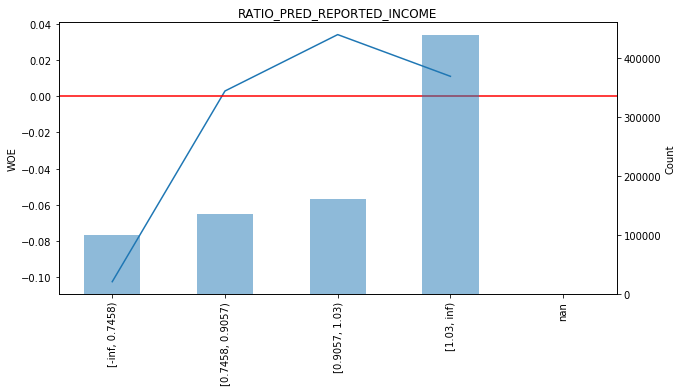

***

### REPORTED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_REPORTED_INCOME,,,,,,,,
"[-inf, 12613.0)",159258.0,11770.0,0.0739,0.1795,0.1917,0.0648,0.0655,0.1907
"[12613.0, 19894.7002)",425969.0,33099.0,0.0777,0.5048,0.5105,0.0112,0.0113,0.5101
"[19894.7002, 21867.0)",103413.0,7851.0,0.0759,0.1197,0.1242,0.0361,0.0365,0.1238
"[21867.0, inf)",146471.0,12852.0,0.0877,0.1960,0.1736,-0.1198,-0.1211,0.1754
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.4626,0.0000


IV: 0.0037
Gini: 2.97


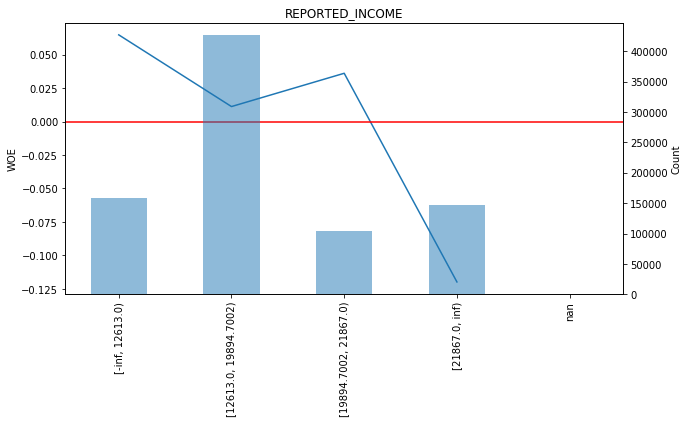

In [151]:
grouping.plot_bins(data=df_train, cols_pred_num=cols_pred_num, cols_pred_cat=cols_pred_cat,
                    mask = pd.Series(df_train["REPORTED_INCOME"]>=0),col_target="RISK_FSTQPD30", 
                   output_folder=r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN", col_weight=None)

In [152]:
woe_columns_to_replace = list()
for column in data_woe.columns:
    if column in df:
        woe_columns_to_replace.append(column)
        print('Column', column ,'dropped as it already existed in the data set.')
df = df.drop(woe_columns_to_replace, axis='columns')
df = df.join(-data_woe)

print('Added WOE variables. Number of columns:',df.shape[1])
cols_woe = [s + '_WOE' for s in cols_pred_num]

Added WOE variables. Number of columns: 25
